<a href="https://colab.research.google.com/github/PKpacheco/final_project_neural_networks/blob/main/Paola_Pacheco_Final_project_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Networks and Deep Learning:
#### Paola Katherine Pacheco
#### Elections

# Executive Summary

This project has as input data set with Twitter texts related to the candidates of the last election in the United States, Donald Trump and Joe Biden.
The main objective is to understand when posts have a positive or negative feeling towards the candidates and how we could understand this as something that would affect the outcome of the elections

For the stages we will use the content of what was published about the candidates, using a previously created dataset available on kaggle.
* [kaggle link](https://statics.teams.cdn.office.net/evergreen-assets/safelinks/1/atp-safelinks.html)


We will pre-process the data so that it undergoes cleaning, removing special characters, links and after that we must tokenize it, to obtain the sentiment, whether positive, negative or neutral.


Furthermore, we will try to explore some of the advanced methods such as stacking long-term memory networks (LSTMs), closed recurrent units (GRUs) and bidirectional recurrent neural networks (RNNs), seeking to improve the accuracy of results.


This analysis seeks to provide metrics to understand the relationship between social networks and the real election results

In [5]:
!pip install autocorrect
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622364 sha256=3070e001decc9e6c7495e23d61417293b77e116c20da36f4c138c3a56d6dda8c
  Stored in directory: /root/.cache/pip/wheels/b5/7b/6d/b76b29ce11ff8e2521c8c7dd0e5bfee4fb1789d76193124343
Successfully built autocorrect
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 6.1 MB/s eta 0:00:00


In [308]:
import emoji
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import string


import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from autocorrect import Speller

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from textblob import TextBlob

from wordcloud import WordCloud

from gensim.models import Word2Vec
import ast


from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (
    Embedding,
    SpatialDropout1D,
    SimpleRNN,
    LSTM,
    GRU,
    Dropout,
    Dense,
    Bidirectional
    )

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# import files
biden_url = 'https://raw.githubusercontent.com/PKpacheco/final_project_neural_networks/main/Bidenall2.csv'
trump_url = 'https://raw.githubusercontent.com/PKpacheco/final_project_neural_networks/main/Trumpall2.csv'

# Cleaning section

In [4]:
# read files
df_biden = pd.read_csv(biden_url)
df_trump = pd.read_csv(trump_url)

In [5]:
df_biden.head()

,user,text
0,MarkHodder3,@JoeBiden And we’ll find out who won in 2026...
1,K87327961G,@JoeBiden Your Democratic Nazi Party cannot be...
2,OldlaceA,@JoeBiden So did Lying Barr
3,penblogger,@JoeBiden It's clear you didnt compose this tw...
4,Aquarian0264,@JoeBiden I will vote in person thank you.


In [6]:
df_trump.head()

,user,text
0,manny_rosen,@sanofi please tell us how many shares the Cr...
1,osi_abdul,"https://t.co/atM98CpqF7 Like, comment, RT #P..."
2,Patsyrw,Your AG Barr is as useless &amp; corrupt as y...
3,seyedebrahimi_m,Mr. Trump! Wake Up! Most of the comments bel...
4,James09254677,After 4 years you think you would have figure...


In [7]:
df_trump['text'][10]

' No president would be able to destroy as you have'

In [8]:
df_biden['text'][10]

'@JoeBiden Voter ID is required otherwise you Democrats will cheat..its been proven.  Have some integrity !'

As we can see, we have first column the user id (twitter) and the second column , the text

In [9]:
# check Nan values
print('Number of NaN values in biden: ', df_biden.isna().sum())
print('Number of NaN values in trump: ', df_trump.isna().sum())

user    0
text    0
dtype: int64

In [11]:
# check duplicates
print('Number of duplicates in biden: ', df_biden.duplicated().sum())
print('Number of duplicates in trump: ', df_trump.duplicated().sum())


Number of duplicates in biden:  0
Number of duplicates in trump:  0


In [12]:
# check missing or null values
print("Total missing values in biden:", df_biden.isnull().sum().sum())
print("Total missing values in trump:", df_trump.isnull().sum().sum())

Total missing values in biden: 0
Total missing values in trump: 0


In [13]:
# instantiate stopwords, lemmatizer and speller
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
spell = Speller(lang='en')

In [14]:
# clean text
def clean_text(text):
    # replace emojis with its meaning
    text = text.apply(lambda x: emoji.demojize(x))

    # remove URLs
    text = text.apply(lambda x: re.sub(r'http\S+', '', x))

    # remove html tags
    text = text.apply(lambda x: re.sub(r'<.*?>', '', x))

    # remove punctuation, inlcuding @ for mentions and # for hashtags
    text = text.apply(lambda x: re.sub(r'[^\w\s]|_', ' ', x))

    # normalize case
    text = text.apply(lambda x: x.lower())

    # remove stopwords
    text = text.apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

    # check if the word is spelled correctly
    text = text.apply(lambda x: spell(x))

    # lemmatize the text
    text = text.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

    # tokenize the text
    text = text.apply(lambda x: word_tokenize(x))


    return text

we clean our data:


    1. Replace emojis with their textual meaning.
    2. Remove URLs from the text.
    3. Remove HTML tags.
    4. Remove punctuation, including @ for mentions and # for hashtags.
    5. Convert text to lowercase for consistency.
    6. Remove stopwords - common words that do not contribute much to the meaning.
    7. Check and correct spelling of words.
    8. Lemmatize the text - reduce words to their base or root form.
    9. Tokenize the text - split it into individual words.


In [15]:
# clean the text using function

df_trump['clean_text'] = clean_text(df_trump['text'])
df_biden['clean_text'] = clean_text(df_biden['text'])


In [16]:
print(df_biden['text'][2])

@JoeBiden So did Lying Barr


In [22]:
# Save cleaned DataFrames to CSV files and push to github (avoid cleaning time)
df_trump.to_csv('cleaned_trump_data.csv', index=False)
df_biden.to_csv('cleaned_biden_data.csv', index=False)

### read the cleaned df

In [1]:
# read the cleaned df from github
url_clean_t = 'https://raw.githubusercontent.com/PKpacheco/final_project_neural_networks/main/cleaned_trump_data.csv'
url_clean_b = 'https://raw.githubusercontent.com/PKpacheco/final_project_neural_networks/main/cleaned_biden_data.csv'


In [9]:
biden = pd.read_csv(url_clean_b)
trump = pd.read_csv(url_clean_t)

In [10]:
# check if new df match with df_biden df
print(biden['text'][2])
print(df_biden['text'][2])

@JoeBiden So did Lying Barr


NameError: ignored

In [51]:
# check if new df match with df_biden df
print(trump['text'][2])
print(df_trump['text'][2])

 Your AG Barr is as useless &amp; corrupt as you are     Rep. Pramila Jayapal #SheGotItRight
 Your AG Barr is as useless &amp; corrupt as you are     Rep. Pramila Jayapal #SheGotItRight


In [11]:
biden.head()

,user,text,clean_text
0,MarkHodder3,@JoeBiden And we’ll find out who won in 2026...,"['joebiden', 'find', '2026']"
1,K87327961G,@JoeBiden Your Democratic Nazi Party cannot be...,"['joebiden', 'democratic', 'nazi', 'party', 'c..."
2,OldlaceA,@JoeBiden So did Lying Barr,"['joebiden', 'lying', 'barr']"
3,penblogger,@JoeBiden It's clear you didnt compose this tw...,"['joebiden', 'clear', 'didnt', 'compose', 'twe..."
4,Aquarian0264,@JoeBiden I will vote in person thank you.,"['joebiden', 'vote', 'person', 'thank']"


In [10]:
trump.head()

,user,text,clean_text
0,manny_rosen,@sanofi please tell us how many shares the Cr...,"['sankei', 'please', 'tell', 'u', 'many', 'sha..."
1,osi_abdul,"https://t.co/atM98CpqF7 Like, comment, RT #P...","['like', 'comment', 'rt', 'prayer4tachantitans..."
2,Patsyrw,Your AG Barr is as useless &amp; corrupt as y...,"['ag', 'barr', 'useless', 'amp', 'corrupt', 'r..."
3,seyedebrahimi_m,Mr. Trump! Wake Up! Most of the comments bel...,"['mr', 'trump', 'wake', 'comment', 'tweet', 'n..."
4,James09254677,After 4 years you think you would have figure...,"['4', 'year', 'think', 'would', 'figured', 'ho..."


# Analyse

## Start work on the cleaned df

In [12]:
# analyse the sentiment in a randon tweet
tweet_biden = TextBlob(biden['text'][5])
tweet_biden.sentiment

Sentiment(polarity=0.03333333333333333, subjectivity=0.19999999999999998)

In [55]:
biden['text'][5]

'@JoeBiden #ALL LIVES MATTER #HUMAN RIGHTS HELP FOR YOUNG MATTEO BENASSI FOR HUMAN RIGHTS FROM ITALY/EUROPE..A PRERO… https://t.co/M94qYHUUs4'

**Polarity: 0.0333**
We observed a positive but very low value, very close to neutral.


**Subjectivity: 0.2**
The value is also low and this means that the tweet is more objective than opinionated.

Overall this tweet suggests that the sentiment is positive and perhaps a fact

In [13]:
# analyse the sentiment in a randon tweet
tweet_trump = TextBlob(trump['text'][2])
tweet_trump.sentiment

Sentiment(polarity=-0.5, subjectivity=0.6)

In [15]:
trump['text'][2]

' Your AG Barr is as useless &amp; corrupt as you are     Rep. Pramila Jayapal #SheGotItRight'

**Polarity: -0.5**
We observed polarity is negative, indicating a more negative sentiment

**Subjectivity: 0.6**
The subjectivity is moderate, suggesting maybe an opinion tone.


This tweet suggests a negative sentiment, with the tweet being moderately subjective or opinionated.

In [16]:
# calculate sentiment for all tweets
def calculate_sentiment(review):
  analysis = TextBlob(review).sentiment
  return pd.Series({'Sentiment Polarity': analysis.polarity, 'Sentiment Subjectivity': analysis.subjectivity})

In [17]:
# apply the sentiment columns to trump df
trump[['polarity', 'subjectivity']] = trump['clean_text'].apply(calculate_sentiment)
print(trump.head())

              user                                               text  \
0      manny_rosen   @sanofi please tell us how many shares the Cr...   
1        osi_abdul   https://t.co/atM98CpqF7  Like, comment, RT #P...   
2          Patsyrw   Your AG Barr is as useless &amp; corrupt as y...   
3  seyedebrahimi_m   Mr. Trump! Wake Up!  Most of the comments bel...   
4    James09254677   After 4 years you think you would have figure...   

                                          clean_text  polarity  subjectivity  
0  ['sankei', 'please', 'tell', 'u', 'many', 'sha...      0.05         0.525  
1  ['like', 'comment', 'rt', 'prayer4tachantitans...      0.00         0.000  
2  ['ag', 'barr', 'useless', 'amp', 'corrupt', 'r...     -0.50         0.600  
3  ['mr', 'trump', 'wake', 'comment', 'tweet', 'n...      0.00         0.000  
4  ['4', 'year', 'think', 'would', 'figured', 'ho...      0.00         0.000  


In [18]:
# apply the sentiment columns
biden[['polarity', 'subjectivity']] = biden['clean_text'].apply(calculate_sentiment)
print(biden.head())

           user                                               text  \
0   MarkHodder3    @JoeBiden And we’ll find out who won in 2026...   
1    K87327961G  @JoeBiden Your Democratic Nazi Party cannot be...   
2      OldlaceA                        @JoeBiden So did Lying Barr   
3    penblogger  @JoeBiden It's clear you didnt compose this tw...   
4  Aquarian0264         @JoeBiden I will vote in person thank you.   

                                          clean_text  polarity  subjectivity  
0                       ['joebiden', 'find', '2026']      0.00         0.000  
1  ['joebiden', 'democratic', 'nazi', 'party', 'c...      0.00         0.000  
2                      ['joebiden', 'lying', 'barr']      0.00         0.000  
3  ['joebiden', 'clear', 'didnt', 'compose', 'twe...      0.05         0.225  
4            ['joebiden', 'vote', 'person', 'thank']      0.00         0.000  


In [19]:
# new column opinion label based on the sentiment polarity
trump["opinion_label"] = np.where(trump["polarity"] > 0, "positive", "negative")
trump.loc[trump["polarity"] == 0, "opinion_label"] = "neutral"

print(trump.head())

              user                                               text  \
0      manny_rosen   @sanofi please tell us how many shares the Cr...   
1        osi_abdul   https://t.co/atM98CpqF7  Like, comment, RT #P...   
2          Patsyrw   Your AG Barr is as useless &amp; corrupt as y...   
3  seyedebrahimi_m   Mr. Trump! Wake Up!  Most of the comments bel...   
4    James09254677   After 4 years you think you would have figure...   

                                          clean_text  polarity  subjectivity  \
0  ['sankei', 'please', 'tell', 'u', 'many', 'sha...      0.05         0.525   
1  ['like', 'comment', 'rt', 'prayer4tachantitans...      0.00         0.000   
2  ['ag', 'barr', 'useless', 'amp', 'corrupt', 'r...     -0.50         0.600   
3  ['mr', 'trump', 'wake', 'comment', 'tweet', 'n...      0.00         0.000   
4  ['4', 'year', 'think', 'would', 'figured', 'ho...      0.00         0.000   

  opinion_label  
0      positive  
1       neutral  
2      negative  
3       

In [20]:
# new column opinion label based on the sentiment polarity
biden["opinion_label"] = np.where(biden["polarity"] > 0, "positive", "negative")
biden.loc[biden["polarity"] == 0, "opinion_label"] = "neutral"

print(biden.head())

           user                                               text  \
0   MarkHodder3    @JoeBiden And we’ll find out who won in 2026...   
1    K87327961G  @JoeBiden Your Democratic Nazi Party cannot be...   
2      OldlaceA                        @JoeBiden So did Lying Barr   
3    penblogger  @JoeBiden It's clear you didnt compose this tw...   
4  Aquarian0264         @JoeBiden I will vote in person thank you.   

                                          clean_text  polarity  subjectivity  \
0                       ['joebiden', 'find', '2026']      0.00         0.000   
1  ['joebiden', 'democratic', 'nazi', 'party', 'c...      0.00         0.000   
2                      ['joebiden', 'lying', 'barr']      0.00         0.000   
3  ['joebiden', 'clear', 'didnt', 'compose', 'twe...      0.05         0.225   
4            ['joebiden', 'vote', 'person', 'thank']      0.00         0.000   

  opinion_label  
0       neutral  
1       neutral  
2       neutral  
3      positive  
4       

# Plots

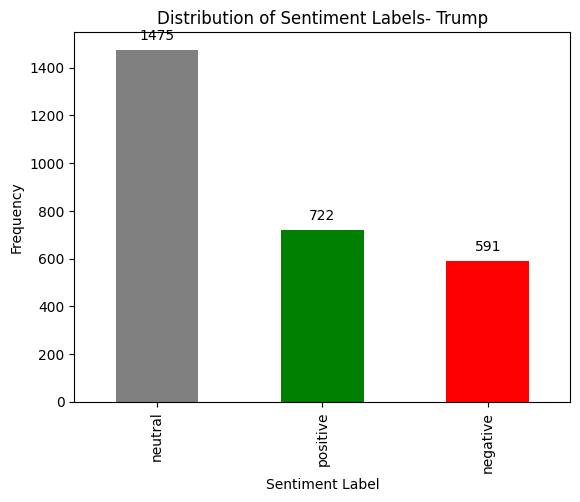

In [21]:
# Plot labels
ax = trump['opinion_label'].value_counts().plot(kind='bar', color=['grey', 'green', 'red'])
plt.title('Distribution of Sentiment Labels- Trump')
plt.xlabel('Sentiment Label')
plt.ylabel('Frequency')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()


We have 1473 neutral tweets, 722 positives and 591 negatives

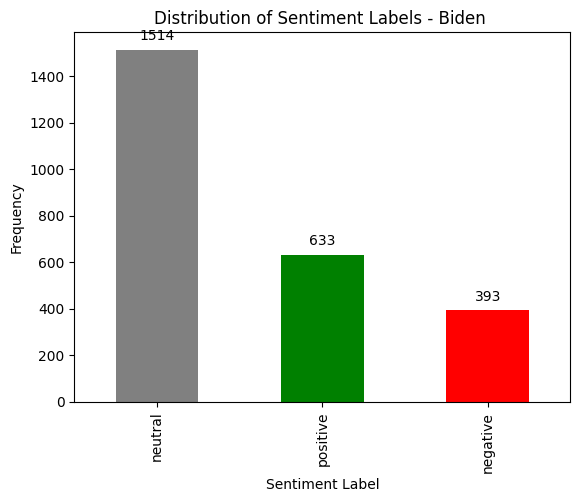

In [22]:
# Plot labels
ax = biden['opinion_label'].value_counts().plot(kind='bar', color=['grey', 'green', 'red'])
plt.title('Distribution of Sentiment Labels - Biden ')
plt.xlabel('Sentiment Label')
plt.ylabel('Frequency')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()


We have 1514 neutral tweets, 633 positives and 393 negatives

In [23]:
# filter rows where 'polarity' is 0 in the 'trump' DataFrame
polarity_zero_t = trump[trump['polarity'] == 0.0000]

# total rows with 'polarity' = 0 and the total number of rows in 'trump'
total_rows_polarity_zero_t = polarity_zero_t.shape[0]
total_rows_trump = trump.shape[0]

# percentage rows 'polarity' = 0 in 'trump'
percentage_polarity_zero_t = (total_rows_polarity_zero_t / total_rows_trump) * 100

# filter rows where  'subjectivity' is 0 in the 'trump' DataFrame
subjectivity_zero_t = trump[trump['subjectivity'] == 0.0000]

# total rows with 'subjectivity' = 0 and the total number of rows in 'trump'
total_rows_subjectivity_zero_t = subjectivity_zero_t.shape[0]

# percentage of rows with 'subjectivity' = 0 in 'trump'
percentage_subjectivity_zero_t = (total_rows_subjectivity_zero_t / total_rows_trump) * 100

# Print the results for 'trump'
print("Total number of rows with 'polarity' = 0 in 'trump':", total_rows_polarity_zero_t)
print("Percentage of rows with 'polarity' = 0 in 'trump': {:.2f}%".format(percentage_polarity_zero_t))
print("Total number of rows with 'subjectivity' = 0 in 'trump':", total_rows_subjectivity_zero_t)
print("Percentage of rows with 'subjectivity' = 0 in 'trump': {:.2f}%".format(percentage_subjectivity_zero_t))


Total number of rows with 'polarity' = 0 in 'trump': 1475
Percentage of rows with 'polarity' = 0 in 'trump': 52.91%
Total number of rows with 'subjectivity' = 0 in 'trump': 1363
Percentage of rows with 'subjectivity' = 0 in 'trump': 48.89%


In [24]:
# filter rows where 'polarity' is 0 in the 'biden' DataFrame
polarity_zero_b = biden[biden['polarity'] == 0.0000]

# total rows with 'polarity' = 0 and the total number of rows in 'biden'
total_rows_polarity_zero_b = polarity_zero_b.shape[0]
total_rows_biden = biden.shape[0]

# percentage rows 'polarity' = 0 in 'biden'
percentage_polarity_zero_b = (total_rows_polarity_zero_b / total_rows_biden) * 100

# filter rows where  'subjectivity' is 0 in the 'biden' DataFrame
subjectivity_zero_b = biden[biden['subjectivity'] == 0.0000]

# total rows with 'subjectivity' = 0 and the total number of rows in 'biden'
total_rows_subjectivity_zero_b = subjectivity_zero_b.shape[0]

# percentage of rows with 'subjectivity' = 0 in 'biden'
percentage_subjectivity_zero_b = (total_rows_subjectivity_zero_b / total_rows_biden) * 100

# Print the results for 'biden'
print("Total number of rows with 'polarity' = 0 in 'biden':", total_rows_polarity_zero_b)
print("Percentage of rows with 'polarity' = 0 in 'biden': {:.2f}%".format(percentage_polarity_zero_b))
print("Total number of rows with 'subjectivity' = 0 in 'biden':", total_rows_subjectivity_zero_b)
print("Percentage of rows with 'subjectivity' = 0 in 'biden': {:.2f}%".format(percentage_subjectivity_zero_b))


Total number of rows with 'polarity' = 0 in 'biden': 1514
Percentage of rows with 'polarity' = 0 in 'biden': 59.61%
Total number of rows with 'subjectivity' = 0 in 'biden': 1381
Percentage of rows with 'subjectivity' = 0 in 'biden': 54.37%


In [25]:
# Trump percentages
count_trump = trump.groupby('opinion_label').count()
total_samples_trump = len(trump)
negative_percentage1 = (count_trump['polarity'][0] / total_samples_trump) * 100
positive_percentage1 = (count_trump['polarity'][1] / total_samples_trump) * 100


In [26]:
# Biden percentages
count_biden = biden.groupby('opinion_label').count()
total_samples_biden = len(biden)
negative_percentage2 = (count_biden['polarity'][0] / total_samples_biden) * 100
positive_percentage2 = (count_biden['polarity'][1] / total_samples_biden) * 100

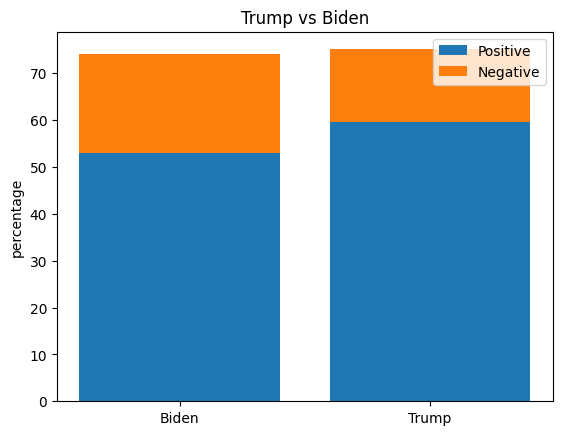

In [27]:
# plot
politicians = ['Biden', 'Trump']
opinion_pos = [positive_percentage1, positive_percentage2]
opinion_neg = [negative_percentage1, negative_percentage2]

plt.bar(x=politicians, height=opinion_pos, label="Positive")
plt.bar(x=politicians, height=opinion_neg, label="Negative", bottom=opinion_pos)
plt.legend()
plt.title("Trump vs Biden")
plt.ylabel("percentage")
plt.show()


In [28]:
# concatenate df

# create a column to identify the candidate
biden['candidate'] = 'biden'
trump['candidate'] = 'trump'

# concatenate df
df_combined = pd.concat([biden, trump], ignore_index=True)

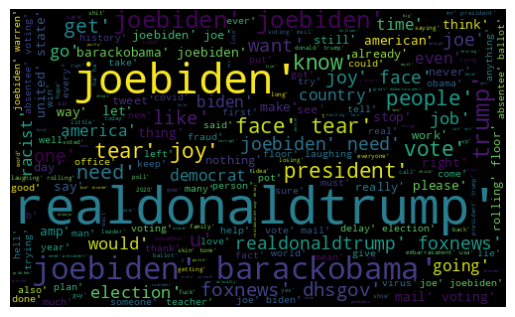

In [29]:
# fancy word plot
allwords = ' '.join([twts for twts in df_combined['clean_text']])
wordcloud = WordCloud(width=500, height=300, random_state=21, max_font_size=119).generate(allwords)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


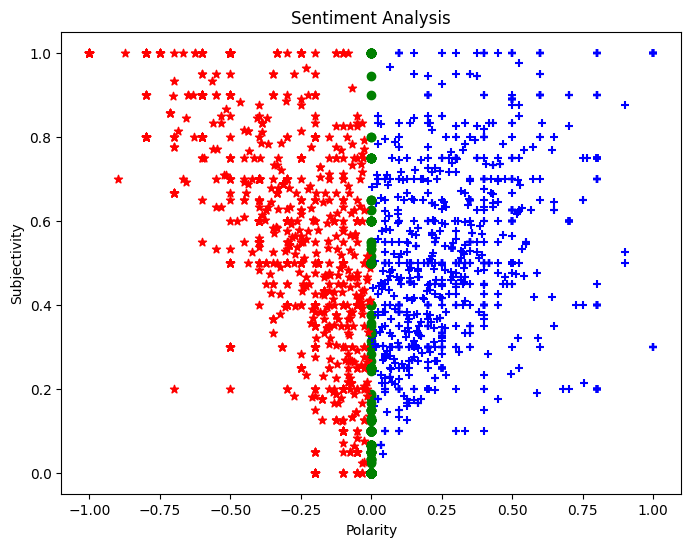

In [30]:
plt.figure(figsize=(8, 6))
for i in range(0, len(df_combined)):
    p = df_combined['polarity'][i]
    if p < 0:
        plt.scatter(df_combined['polarity'][i], df_combined['subjectivity'][i], color='red', marker='*')
    elif p == 0:
        plt.scatter(df_combined['polarity'][i], df_combined['subjectivity'][i], color='green', marker='o')
    else:
        plt.scatter(df_combined['polarity'][i], df_combined['subjectivity'][i], color='blue', marker='+')

plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.title('Sentiment Analysis')
plt.show()


* Polarity < 0 ---> negative tweet
* Polarity==0 ---> Neutral tweet
* Polarity > 0 ---> Positive tweet

The plot using the df combination shows that the positive and negative twwts are very equal, also shows few neutral tweets.

In [31]:
texts_trump = df_combined[df_combined['candidate'] == 'trump']['clean_text']

texts_biden = df_combined[df_combined['candidate'] == 'biden']['clean_text']


In [32]:
# convert string representation of lists to actual lists
texts_trump = texts_trump.apply(ast.literal_eval)
texts_biden = texts_biden.apply(ast.literal_eval)

In [33]:
# Word2Vec Trump
model_trump = Word2Vec(sentences=texts_trump, vector_size=10, window=1, min_count=1, workers=4)

#  Word2Vec Biden
model_biden = Word2Vec(sentences=texts_biden, vector_size=10, window=1, min_count=1, workers=4)


In [34]:
# similar words to 'trump'
data_sim_trump = model_trump.wv.most_similar('trump', topn=25)
x_trump = [i for i, j in data_sim_trump]
y_trump = [j for i, j in data_sim_trump]

print("Words similar to 'trump':", x_trump)

Words similar to 'trump': ['racist', 'democrat', 'right', 'election', 'need', 'losing', 'american', 'u', 'red', 'office', 'like', 'realdonaldtrump', 'one', 'even', 'mail', 'man', 'work', 'really', 'get', 'know', 'would', 'lose', 'day', 'ballot', 'school']


In [35]:
# similar words to 'biden'
data_sim_biden = model_biden.wv.most_similar('biden', topn=25)
x_biden = [i for i, j in data_sim_biden]
y_biden = [j for i, j in data_sim_biden]

# Print the similar words to 'biden'
print("Words similar to 'biden':", x_biden)


Words similar to 'biden': ['please', 'virus', 'joe', 'president', 'see', 'way', 'thank', 'thing', 'right', 'would', 'stop', 'voting', 'country', 'go', 'vp', 'still', 'hand', 'need', 'people', 'american', 'democrat', 'joebiden', 'absentee', 'one', 'world']


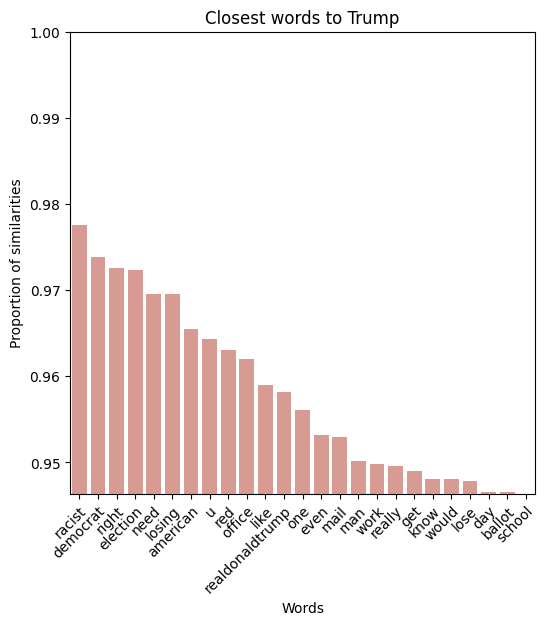

In [39]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.barplot(x=x_trump, y=y_trump, color="salmon", saturation=.5, ax=ax)
ax.set_title('Closest words to Trump')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.set_ylim(np.min(y_trump), 1)
ax.set_xlabel('Words')
ax.set_ylabel('Proportion of similarities')

plt.show()


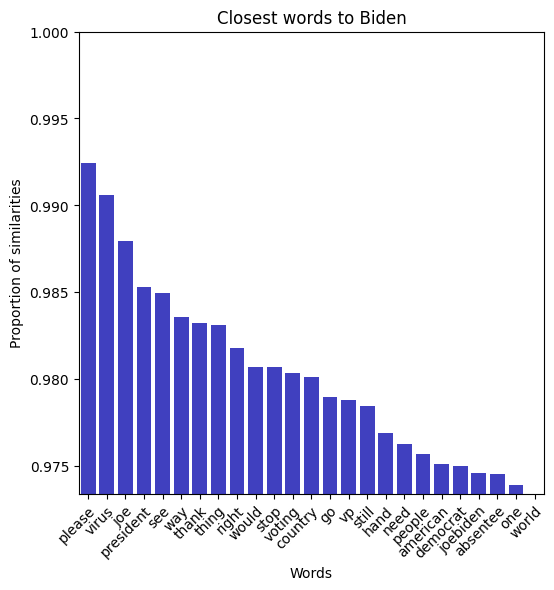

In [40]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.barplot(x=x_biden, y=y_biden, color="blue", saturation=.5, ax=ax)
ax.set_title('Closest words to Biden')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.set_ylim(np.min(y_biden), 1)
ax.set_xlabel('Words')
ax.set_ylabel('Proportion of similarities')

plt.show()


Pre processing data

In [41]:
df_combined.tail()

,user,text,clean_text,polarity,subjectivity,opinion_label,candidate
5323,4diva63,"@realDonaldTrump For the 1/100 time, absentee ...","['realdonaldtrump', '1', '100', 'time', 'absen...",0.000,0.250000,neutral,trump
5324,hidge826,@realDonaldTrump If you’re so scared of losing...,"['realdonaldtrump', 'scared', 'losing', 'resign']",0.000,0.000000,neutral,trump
5325,SpencerRossy,@realDonaldTrump I rarely get involved with fo...,"['realdonaldtrump', 'rarely', 'get', 'involved...",0.225,0.637963,positive,trump
5326,ScoobyMcpherson,@realDonaldTrump This is the moment when Trump...,"['realdonaldtrump', 'moment', 'trump', 'begin'...",0.000,0.000000,neutral,trump
5327,bjklinz,"@realDonaldTrump I’m sorry, Donald. No. #POTUS","['realdonaldtrump', 'sorry', 'donald', 'pot']",-0.500,1.000000,negative,trump


In [42]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5328 entries, 0 to 5327
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user           5328 non-null   object 
 1   text           5328 non-null   object 
 2   clean_text     5328 non-null   object 
 3   polarity       5328 non-null   float64
 4   subjectivity   5328 non-null   float64
 5   opinion_label  5328 non-null   object 
 6   candidate      5328 non-null   object 
dtypes: float64(2), object(5)
memory usage: 291.5+ KB


In [50]:
# move the label to a new df and remove from the df_combined
y_label = df_combined['opinion_label']
X = df_combined.drop(['opinion_label'], axis=1)

In [51]:
# one-Hot Encode candidate
X = pd.get_dummies(X, columns=['candidate'])

In [52]:
X.head()

,user,text,clean_text,polarity,subjectivity,candidate_biden,candidate_trump
0,MarkHodder3,@JoeBiden And we’ll find out who won in 2026...,"['joebiden', 'find', '2026']",0.00,0.000,1,0
1,K87327961G,@JoeBiden Your Democratic Nazi Party cannot be...,"['joebiden', 'democratic', 'nazi', 'party', 'c...",0.00,0.000,1,0
2,OldlaceA,@JoeBiden So did Lying Barr,"['joebiden', 'lying', 'barr']",0.00,0.000,1,0
3,penblogger,@JoeBiden It's clear you didnt compose this tw...,"['joebiden', 'clear', 'didnt', 'compose', 'twe...",0.05,0.225,1,0
4,Aquarian0264,@JoeBiden I will vote in person thank you.,"['joebiden', 'vote', 'person', 'thank']",0.00,0.000,1,0


In [53]:
y_label

0        neutral
1        neutral
2        neutral
3       positive
4        neutral
          ...   
5323     neutral
5324     neutral
5325    positive
5326     neutral
5327    negative
Name: opinion_label, Length: 5328, dtype: object

In [56]:
label_encoder = LabelEncoder()
y_labels_encoded = label_encoder.fit_transform(y_label)

In [57]:
y_labels_encoded

array([1, 1, 1, ..., 2, 1, 0])

In [58]:
# reshape into 2d array
labels_reshap = y_labels_encoded.reshape(-1, 1)

In [60]:
labels_reshap.shape

(5328, 1)

In [68]:
# get the labels
labels = label_encoder.classes_

# print the labels and their corresponding integer values
for i, label in enumerate(labels):
    print(f'{label} : {i}')

negative : 0
neutral : 1
positive : 2


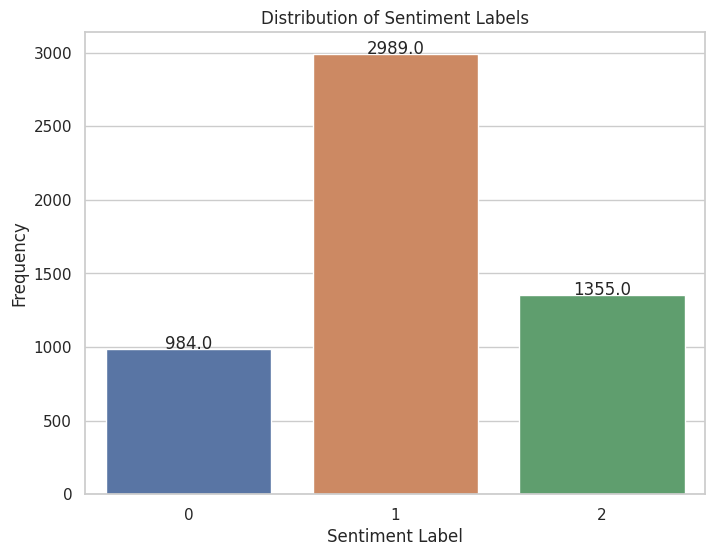

In [74]:
# plot labels
labels_flat = labels_reshap.flatten()

plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")

ax = sns.countplot(x=labels_flat)

ax.set_title('Distribution of Sentiment Labels')
ax.set_xlabel('Sentiment Label')
ax.set_ylabel('Frequency')

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline')

plt.show()


These are the labels:

* negative : 0
* neutral : 1
* positive : 2

We can see that the majority of tweets are neutral, then with less than half in quantity we have the positive ones and then the negative ones.

In [54]:
X = X.drop(columns=['user'])
X.head()

,text,clean_text,polarity,subjectivity,candidate_biden,candidate_trump
0,@JoeBiden And we’ll find out who won in 2026...,"['joebiden', 'find', '2026']",0.00,0.000,1,0
1,@JoeBiden Your Democratic Nazi Party cannot be...,"['joebiden', 'democratic', 'nazi', 'party', 'c...",0.00,0.000,1,0
2,@JoeBiden So did Lying Barr,"['joebiden', 'lying', 'barr']",0.00,0.000,1,0
3,@JoeBiden It's clear you didnt compose this tw...,"['joebiden', 'clear', 'didnt', 'compose', 'twe...",0.05,0.225,1,0
4,@JoeBiden I will vote in person thank you.,"['joebiden', 'vote', 'person', 'thank']",0.00,0.000,1,0


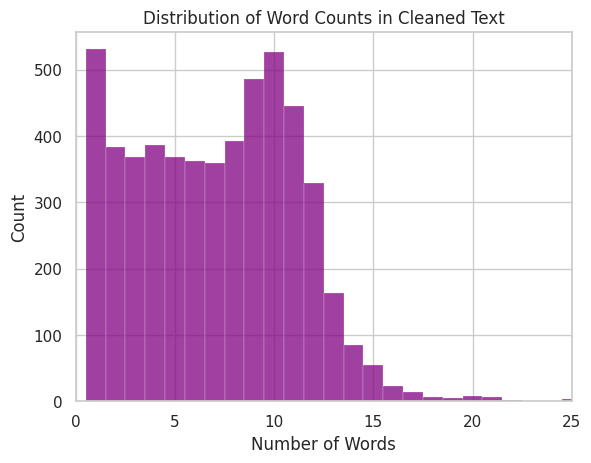

In [101]:
# Calculate the length of cleaned_text in terms of words
df_combined['word_count'] = df_combined['clean_text'].apply(lambda x: len(x.split()))

# Plot the distribution of word counts
# plt.figure(figsize=(10, 6))
sns.histplot(df_combined['word_count'], color='purple', discrete=True)

plt.title('Distribution of Word Counts in Cleaned Text')
plt.xlabel('Number of Words')
plt.ylabel('Count')
plt.xlim(0, 25)

plt.show()


In [117]:
# filter tweets with 1 word
tweets_with_one_word = df_combined[df_combined['word_count'] == 1]

# display 5 tweets with 1 word
for index, tweet in tweets_with_one_word.tail().iterrows():
    print(f"tweet index: {index}")
    print(f"text: {tweet['clean_text']}")
    print("------------------")


tweet index: 5257
text: ['realdonaldtrump']
------------------
tweet index: 5268
text: ['realdonaldtrump']
------------------
tweet index: 5281
text: ['realdonaldtrump']
------------------
tweet index: 5286
text: ['realdonaldtrump']
------------------
tweet index: 5319
text: ['realdonaldtrump']
------------------


In [110]:
# calculate the vocab size
corpus = df_combined['clean_text'].values
tokenizer = Tokenizer()

#fit tokenizer on tweets
tokenizer.fit_on_texts(corpus)

# create a mapping of words with unique words
word_index = tokenizer.word_index

In [112]:
# len of vocab size
vocab_size = len(word_index)
vocab_size

5582

We have our `max_len` = 17, from the histogram we can see that a significant part of sequence has a length around 8 to 12 words.

We'll use `max_len` = 17 and for the vocabulary size 5582


In [185]:
labels_reshap

array([[1],
       [1],
       [1],
       ...,
       [2],
       [1],
       [0]])

# Split data and modeling

In [187]:
# split the data 70% test, 15% validation and 15% test

X_train, X_temp, y_train, y_temp = train_test_split(X['clean_text'], labels_reshap, test_size=0.3, random_state=42)

#  split the temp into validation and test (50% for each one)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [188]:
print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Testing set size:", len(X_test))

Training set size: 3729
Validation set size: 799
Testing set size: 800


In [189]:
print("Train X_train shape:", X_train.shape)
print("Train y_train shape:", y_train.shape)
print()

print("Validation X_val shape:", X_val.shape)
print("Validation y_valshape:",y_val.shape)
print()

print("Test X_test shape:", X_test.shape)
print("Test y_test shape:",y_test.shape)



Train X_train shape: (3729,)
Train y_train shape: (3729, 1)

Validation X_val shape: (799,)
Validation y_valshape: (799, 1)

Test X_test shape: (800,)
Test y_test shape: (800, 1)


In [190]:
# define the vocabulary size
num_words = 5582

# define an upper limit on the length of the sequences
sequence_length = 17

In [191]:
# instantiate the tokenizer
tokenizer = Tokenizer(num_words=num_words)

# fit the tokenizer on the train data
tokenizer.fit_on_texts(X_train)

In [192]:
# instantiate the tokenizer
tokenizer = Tokenizer(num_words=num_words)

# fit the tokenizer on the train data
tokenizer.fit_on_texts(X_train)

In [193]:
# convert the text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [206]:
# check the conversion, 10 first lines
for i in range(10):
    print(f"sequence {i + 1}: {X_train_seq[i]}")
    print()

sequence 1: [2, 2209, 1130, 13, 2210, 1487, 2211, 38]

sequence 2: [2]

sequence 3: [1, 400, 114, 49, 315, 21, 56, 9, 5, 115, 11, 90, 114, 49, 121, 2212, 78, 48]

sequence 4: [1, 528, 3, 2213, 2214, 472, 434, 22, 73, 778, 103]

sequence 5: [2, 88, 29, 1131, 401, 928, 929, 1488, 402, 178, 2215]

sequence 6: [7, 42, 2216, 2217, 1132, 590, 930]

sequence 7: [1, 3, 1133]

sequence 8: [2, 316, 675, 9, 5, 2218, 188, 1489, 779, 1490, 529]

sequence 9: [2, 2219]

sequence 10: [2, 1134, 198, 372, 13, 150, 10]



In [201]:
# pad the sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=sequence_length)
X_val_pad = pad_sequences(X_val_seq, maxlen=sequence_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=sequence_length)

In [205]:
# check the conversion, 5 first lines
for i in range(5):
    print(f"sequence {i + 1}: {X_train_pad[i]}")
    print()

sequence 1: [   0    0    0    0    0    0    0    0    0    2 2209 1130   13 2210
 1487 2211   38]

sequence 2: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]

sequence 3: [ 400  114   49  315   21   56    9    5  115   11   90  114   49  121
 2212   78   48]

sequence 4: [   0    0    0    0    0    0    1  528    3 2213 2214  472  434   22
   73  778  103]

sequence 5: [   0    0    0    0    0    0    2   88   29 1131  401  928  929 1488
  402  178 2215]



# Models

In [208]:
# our output has 3 classes
OUTPUT_UNITS = 3
# for multiclass classification
OUTPUT_ACT = 'softmax'

### Functions to use with models

In [251]:
def compile_model(model):
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

In [255]:
def train_model(model,
                X_train,
                y_train,
                X_val,
                y_val,
                epochs=5,
                batch_size=128):
    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val))
    return history


In [257]:
def display_results(history, model_name):
    print(f"{model_name} Training Accuracy: {history.history['accuracy'][-1]}")
    print(f"{model_name} Validation Accuracy: {history.history['val_accuracy'][-1]}")

In [300]:
def plot_confusion_matrix(model, X_val_pad, y_val):
    y_pred_prob = model.predict(X_val_pad)
    y_pred = np.argmax(y_pred_prob, axis=1)

    cm = confusion_matrix(y_val, y_pred)

    plt.title(f"Confusion Matrix {model.name}")
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False,
              xticklabels=['Negative(Pred)', 'Neutral(Pred)', 'Positive(Pred)'],
             yticklabels=['Negative(atual) ', 'Neutral(atual)', 'Positive(atual)'])
    plt.show()

    return cm

### RNN

In [211]:
# Create the model
model_RNN = Sequential()

# Embedding layer with the output dimension matching the units in SimpleRNN
model_RNN.add(Embedding(input_dim=num_words, output_dim=128, input_length=sequence_length))

model_RNN.add(SpatialDropout1D(0.4))

model_RNN.add(SimpleRNN(128))

model_RNN.add(Dropout(0.4))

model_RNN.add(Dense(units=OUTPUT_UNITS, activation=OUTPUT_ACT))

model_RNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 17, 128)           714496    
                                                                 
 spatial_dropout1d (Spatial  (None, 17, 128)           0         
 Dropout1D)                                                      
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 747779 (2.85 MB)
Trainable params: 747779 (2.85 MB)
Non-trainable params: 0 (0.00 Byte)
____________________

In [253]:
# compile model RNN
compile_model(model_RNN)

In [256]:
# Train the RNN model
history_RNN = train_model(model_RNN, X_train_pad, y_train, X_val_pad, y_val)

Epoch 1/5
30/30 [==============================] - 6s 68ms/step - loss: 0.0146 - accuracy: 0.9981 - val_loss: 0.9418 - val_accuracy: 0.7509
Epoch 2/5
30/30 [==============================] - 1s 41ms/step - loss: 0.0103 - accuracy: 0.9979 - val_loss: 1.0056 - val_accuracy: 0.7660
Epoch 3/5
30/30 [==============================] - 1s 41ms/step - loss: 0.0072 - accuracy: 0.9989 - val_loss: 1.0536 - val_accuracy: 0.7509
Epoch 4/5
30/30 [==============================] - 1s 40ms/step - loss: 0.0047 - accuracy: 0.9992 - val_loss: 0.9757 - val_accuracy: 0.7897
Epoch 5/5
30/30 [==============================] - 2s 77ms/step - loss: 0.0049 - accuracy: 0.9992 - val_loss: 1.0984 - val_accuracy: 0.7672


In [258]:
display_results(history_RNN, 'RNN')

RNN Training Accuracy: 0.9991955161094666
RNN Validation Accuracy: 0.767208993434906


In [259]:
#save models config
import os

# directory
directory = '/content/drive/MyDrive/NN_models'

# else create the directory
if not os.path.exists(directory):
    os.makedirs(directory)

In [260]:
# Save the model
model_RNN.save('/content/drive/MyDrive/NN_models/model_RNN.keras')

25/25 [==============================] - 0s 5ms/step


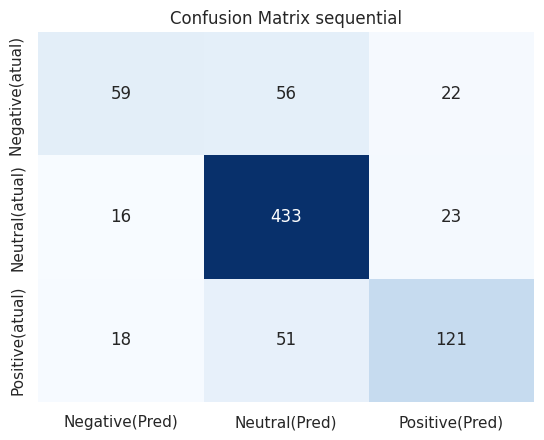

array([[ 59,  56,  22],
       [ 16, 433,  23],
       [ 18,  51, 121]])

In [301]:
plot_confusion_matrix(model_RNN, X_val_pad, y_val)

### LSTM

In [244]:
# Create the model
model_LSTM = Sequential()

model_LSTM.add(Embedding(input_dim=num_words, output_dim=128, input_length=sequence_length))

model_LSTM.add(SpatialDropout1D(0.4))

model_LSTM.add(LSTM(128))

model_LSTM.add(Dropout(0.4))

model_LSTM.add(Dense(units=OUTPUT_UNITS, activation=OUTPUT_ACT))

model_LSTM.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 17, 128)           714496    
                                                                 
 spatial_dropout1d_1 (Spati  (None, 17, 128)           0         
 alDropout1D)                                                    
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 846467 (3.23 MB)
Trainable params: 846467 (3.23 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [263]:
# compile the model
compile_model(model_LSTM)

In [264]:
# Train
history_LSTM = train_model(model_LSTM, X_train_pad, y_train, X_val_pad, y_val)

Epoch 1/5
30/30 [==============================] - 57s 104ms/step - loss: 0.0151 - accuracy: 0.9965 - val_loss: 0.6514 - val_accuracy: 0.8861
Epoch 2/5
30/30 [==============================] - 2s 82ms/step - loss: 0.0111 - accuracy: 0.9976 - val_loss: 0.6720 - val_accuracy: 0.8911
Epoch 3/5
30/30 [==============================] - 4s 127ms/step - loss: 0.0051 - accuracy: 0.9992 - val_loss: 0.6663 - val_accuracy: 0.8911
Epoch 4/5
30/30 [==============================] - 3s 102ms/step - loss: 0.0066 - accuracy: 0.9981 - val_loss: 0.6138 - val_accuracy: 0.8786
Epoch 5/5
30/30 [==============================] - 3s 89ms/step - loss: 0.0075 - accuracy: 0.9987 - val_loss: 0.6897 - val_accuracy: 0.8911


In [267]:
display_results(history_LSTM, 'LSTM')

LSTM Training Accuracy: 0.9986591339111328
LSTM Validation Accuracy: 0.8911138772964478


In [266]:
# Save the model
model_RNN.save('/content/drive/MyDrive/NN_models/model_LSTM.keras')

25/25 [==============================] - 1s 23ms/step


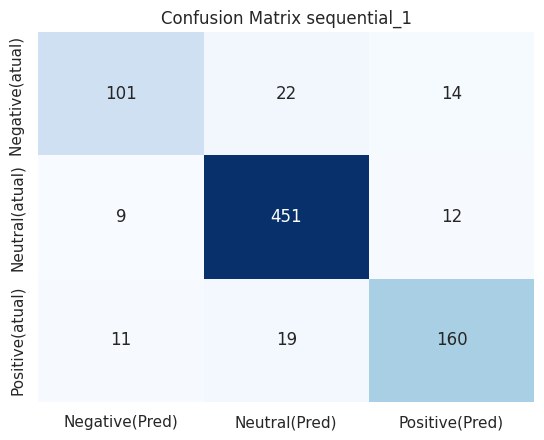

array([[101,  22,  14],
       [  9, 451,  12],
       [ 11,  19, 160]])

In [302]:
plot_confusion_matrix(model_LSTM, X_val_pad, y_val)

### LSTM 2

In [281]:
#lstm model 2
model_LSTM_2 = Sequential()

model_LSTM_2.add(Embedding(input_dim=num_words, output_dim=128, input_length=sequence_length))

model_LSTM_2.add(SpatialDropout1D(0.4))

model_LSTM_2.add(LSTM(64))

model_LSTM_2.add(Dropout(0.4))

model_LSTM_2.add(Dense(units=OUTPUT_UNITS, activation=OUTPUT_ACT))
model_LSTM_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 17, 128)           714496    
                                                                 
 spatial_dropout1d_3 (Spati  (None, 17, 128)           0         
 alDropout1D)                                                    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 764099 (2.91 MB)
Trainable params: 764099 (2.91 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [282]:
compile_model(model_LSTM_2)

In [283]:
# Train
history_LSTM_2 = train_model(model_LSTM_2, X_train_pad, y_train, X_val_pad, y_val)

Epoch 1/5
30/30 [==============================] - 10s 138ms/step - loss: 0.9592 - accuracy: 0.5473 - val_loss: 0.8589 - val_accuracy: 0.5995
Epoch 2/5
30/30 [==============================] - 3s 107ms/step - loss: 0.8413 - accuracy: 0.6173 - val_loss: 0.7883 - val_accuracy: 0.6658
Epoch 3/5
30/30 [==============================] - 4s 122ms/step - loss: 0.7073 - accuracy: 0.7155 - val_loss: 0.6713 - val_accuracy: 0.7084
Epoch 4/5
30/30 [==============================] - 3s 103ms/step - loss: 0.4617 - accuracy: 0.8091 - val_loss: 0.5356 - val_accuracy: 0.8010
Epoch 5/5
30/30 [==============================] - 2s 74ms/step - loss: 0.2563 - accuracy: 0.9193 - val_loss: 0.4857 - val_accuracy: 0.8348


In [284]:
display_results(history_LSTM_2, 'LSTM_2')

LSTM_2 Training Accuracy: 0.9192813038825989
LSTM_2 Validation Accuracy: 0.8347935080528259


In [303]:
# Save the model
model_LSTM_2.save('/content/drive/MyDrive/NN_models/model_LSTM_2.keras')

25/25 [==============================] - 1s 10ms/step


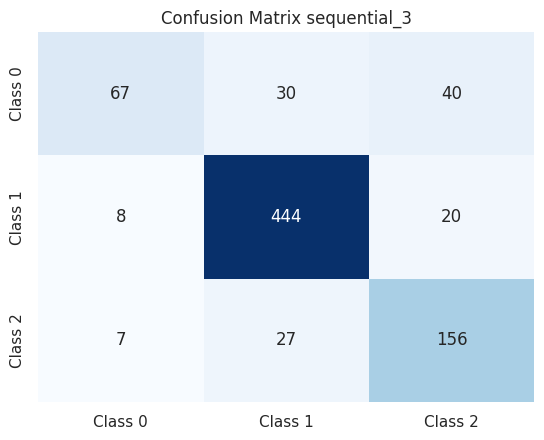

array([[ 67,  30,  40],
       [  8, 444,  20],
       [  7,  27, 156]])

In [288]:
plot_confusion_matrix(model_LSTM_2, X_val_pad, y_val)

### GRU

In [269]:
# Create the model
model_GRU = Sequential()

model_GRU.add(Embedding(input_dim=num_words, output_dim=128, input_length=sequence_length))

model_GRU.add(SpatialDropout1D(0.5))

model_GRU.add(GRU(128, reset_after=False))

model_GRU.add(Dropout(0.5))
model_GRU.add(Dense(units=OUTPUT_UNITS, activation=OUTPUT_ACT))

model_GRU.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 17, 128)           714496    
                                                                 
 spatial_dropout1d_2 (Spati  (None, 17, 128)           0         
 alDropout1D)                                                    
                                                                 
 gru (GRU)                   (None, 128)               98688     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 3)                 387       
                                                                 
Total params: 813571 (3.10 MB)
Trainable params: 813571 (3.10 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [270]:
# compile the model
compile_model(model_GRU)

In [273]:
# Train
history_GRU = train_model(model_GRU, X_train_pad, y_train, X_val_pad, y_val)

Epoch 1/5
30/30 [==============================] - 5s 158ms/step - loss: 0.1170 - accuracy: 0.9654 - val_loss: 0.4299 - val_accuracy: 0.8861
Epoch 2/5
30/30 [==============================] - 6s 193ms/step - loss: 0.0664 - accuracy: 0.9820 - val_loss: 0.4570 - val_accuracy: 0.8849
Epoch 3/5
30/30 [==============================] - 3s 110ms/step - loss: 0.0399 - accuracy: 0.9893 - val_loss: 0.4653 - val_accuracy: 0.8899
Epoch 4/5
30/30 [==============================] - 3s 92ms/step - loss: 0.0306 - accuracy: 0.9928 - val_loss: 0.4413 - val_accuracy: 0.8999
Epoch 5/5
30/30 [==============================] - 3s 91ms/step - loss: 0.0271 - accuracy: 0.9946 - val_loss: 0.4373 - val_accuracy: 0.8899


In [276]:
display_results(history_GRU, 'GRU')

GRU Training Accuracy: 0.9946366548538208
GRU Validation Accuracy: 0.8898622989654541


In [277]:
# Save the model
model_RNN.save('/content/drive/MyDrive/NN_models/model_GRU.keras')

25/25 [==============================] - 0s 9ms/step


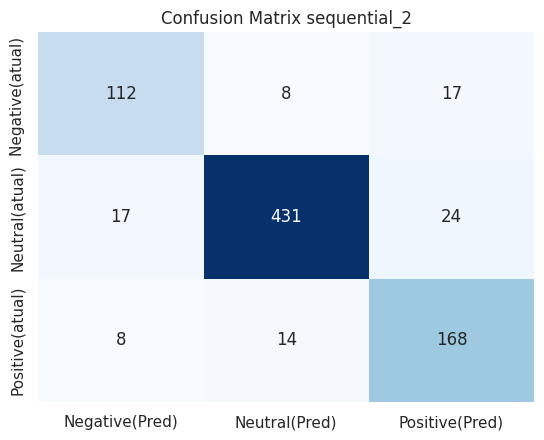

array([[112,   8,  17],
       [ 17, 431,  24],
       [  8,  14, 168]])

In [304]:
plot_confusion_matrix(model_GRU, X_val_pad, y_val)

### table with all models result and comments

In [289]:
display_results(history_RNN, 'RNN')
print()
display_results(history_LSTM, 'LSTM')
print()
display_results(history_LSTM_2, 'LSTM_2')
print()
display_results(history_GRU, 'GRU')

RNN Training Accuracy: 0.9991955161094666
RNN Validation Accuracy: 0.767208993434906

LSTM Training Accuracy: 0.9345669150352478
LSTM Validation Accuracy: 0.8798497915267944

LSTM_2 Training Accuracy: 0.9192813038825989
LSTM_2 Validation Accuracy: 0.8347935080528259

GRU Training Accuracy: 0.9946366548538208
GRU Validation Accuracy: 0.8898622989654541



**Simple RNN Model:**
- Simple architecture with a single layer of SimpleRNN.
- High training accuracy (close to 100%) but lower validation accuracy.
- It looks like an  overfitting by the  gap between training and validation accuracy.

**LSTM Model:**
- More complex architecture with LSTM layer for capturing long-term dependencies.
- Good training and validation accuracy.
- Best model

**LSTM_2 Model:**
- Similar to the LSTM model but with a smaller LSTM layer.
- Reasonable accuracy but lower than the first LSTM model.

**GRU Model:**
- Utilizes GRU (Gated Recurrent Unit) layer, a variation of LSTM with fewer parameters.
- High training and high validation accuracy.
- Training was fast because of fewer parameters

**Other**
- All models include an embedding layer, it means, convert words to numerical vectors.
- SpatialDropout1D is for regularization, dropping entire 1D feature maps.
- Dropout layers are used for regularization to prevent overfitting.
- Dense layer at the end with softmax activation for multi-class classification.

**Training Results:**
- RNN achieved very high training accuracy but I beliee it's an overfitting due to low validation.
- LSTM performed well on both training and validation sets.
- LSTM_2 demonstrated reasonable performance with slightly reduced complexity.
- GRU achieved high accuracy and faster training.

**LSTM is the best model**


### best model traning with test

In [290]:
model_best = model_LSTM

In [291]:
# calculate the test accuracy for LSTM best model
test_acc = model_best.evaluate(X_test_pad, y_test)[1]
# print the test accuracy
print(f'Testing Accuracy: {test_acc:.4f}')

25/25 [==============================] - 1s 24ms/step - loss: 0.9296 - accuracy: 0.8500
Testing Accuracy: 0.8500


25/25 [==============================] - 1s 39ms/step


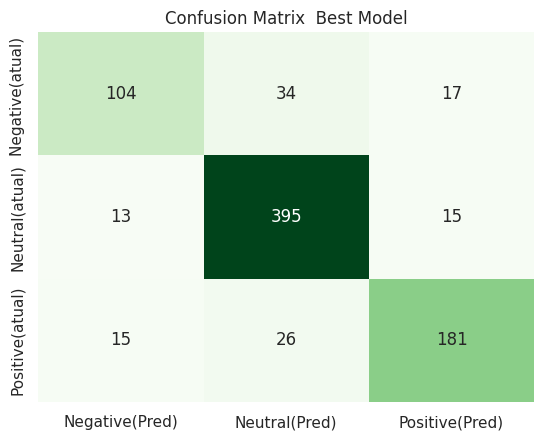

In [305]:
labels = label_encoder.classes_

# make predictions
y_test_pred = model_best.predict(X_test_pad)

# get the labels
y_test_pred_labels = np.argmax(y_test_pred, axis=1)

# create the confusion matrix
cm = confusion_matrix(y_test, y_test_pred_labels)

plt.title(f"Confusion Matrix  Best Model")
sns.heatmap(cm, annot=True, fmt='g', cmap='Greens', cbar=False,
          xticklabels=['Negative(Pred)', 'Neutral(Pred)', 'Positive(Pred)'],
            yticklabels=['Negative(atual) ', 'Neutral(atual)', 'Positive(atual)'])
plt.show()



In [307]:
# other metrics
print(classification_report(y_test, y_test_pred_labels, target_names=labels))

              precision    recall  f1-score   support

    negative       0.79      0.67      0.72       155
     neutral       0.87      0.93      0.90       423
    positive       0.85      0.82      0.83       222

    accuracy                           0.85       800
   macro avg       0.84      0.81      0.82       800
weighted avg       0.85      0.85      0.85       800



In [309]:
from sklearn.metrics import balanced_accuracy_score

print(f'Balanced Accuracy: {balanced_accuracy_score(y_test, y_test_pred_labels):.4f}')

Balanced Accuracy: 0.8067


### Last comments

**Precision:** number of true positives divided by the sum of true positives and false positives.

- Precision for 'negative': 79% of predicted negative instances are correct
- Precision for 'neutral': 87% of predicted neutral instances are correct
- Precision for 'positive': 85% of predicted positive instances are correct

**Recall:** true positives divided by the sum of true positives and false negatives.

- Recall for 'negative':67% of actual negative instances are correct
- Recall for 'neutral': 93% of actual neutral instances are correct
- Recall for 'positive':82% of actual positive instances are correct

**F1-score:**  mean of precision and recall.

- F1-score for 'negative': 0.72
- F1-score for 'neutral': 0.90
- F1-score for 'positive': 0.83

**Support:** number of  instances for each class in the test set, we are using



For **'negative'** sentiment, the precision is 0.79, recall is 0.67, and F1-score is 0.72. The model can identify the negative sentiment but some instances are not classified correctly.

For **'neutral'** sentiment, the model have a good precison well with a precision of 0.87, recall of 0.93, and F1-score of 0.90. The model works with neutral sentiment.

For **'positive'** sentiment, the precision is 0.85, recall is 0.82, and F1-score is 0.83. It's a good performance.



### Tweets prediction with test set

In [456]:
sample_size = 20

# random indices
random_indices = np.random.choice(X_test.shape[0], sample_size, replace=False)

# print original tweets, and the actual and predicted labels
for index in random_indices:
    tweet_text = df_combined.iloc[X_test.index[index]]['text']
    true_label = labels[y_test[index][0]]
    predicted_label = labels[y_test_pred_labels[index]]
    candidate = df_combined.iloc[X_test.index[index]]['candidate']

    print("Tweet:", tweet_text)
    print("True Label:", true_label)
    print("Predicted Label:", predicted_label)
    print("Candidate:", candidate)

    print("--------------------")


Tweet:  @FoxNews Trump, you totally have forgotten how you got the position you hold now. One thing you sh… https://t.co/aDTFSHxB4n
True Label: neutral
Predicted Label: negative
Candidate: trump
--------------------
Tweet:  Thank you for all you've done to protect Americans from these evil forces right now. It's a spirit… https://t.co/a5IRVSMuRE
True Label: negative
Predicted Label: positive
Candidate: trump
--------------------
Tweet: @realDonaldTrump @FoxNews @DHSgov You’re a funny guy.
True Label: positive
Predicted Label: positive
Candidate: trump
--------------------
Tweet:  Yet you still haven't done anything
True Label: neutral
Predicted Label: neutral
Candidate: trump
--------------------
Tweet:  Wow- this makes me sad. Sincerely, a white middle class suburbanite.
True Label: negative
Predicted Label: negative
Candidate: trump
--------------------
Tweet: @JoeBiden https://t.co/a46erwUEcN
True Label: neutral
Predicted Label: neutral
Candidate: biden
--------------------
Tweet: @

In [454]:
# get numbers for each candidate
candidate_label_summary = {}

for index in range(X_test.shape[0]):
    predicted_label = labels[y_test_pred_labels[index]]
    candidate = df_combined.iloc[X_test.index[index]]['candidate']

    if not candidate_label_summary.get(candidate):
        candidate_label_summary[candidate] = {predicted_label: 1}
    else:
        candidate_label_summary[candidate][predicted_label] = candidate_label_summary[candidate].get(predicted_label, 0) + 1


print(candidate_label_summary)


{'biden': {'neutral': 238, 'positive': 108, 'negative': 44}, 'trump': {'negative': 88, 'positive': 105, 'neutral': 217}}


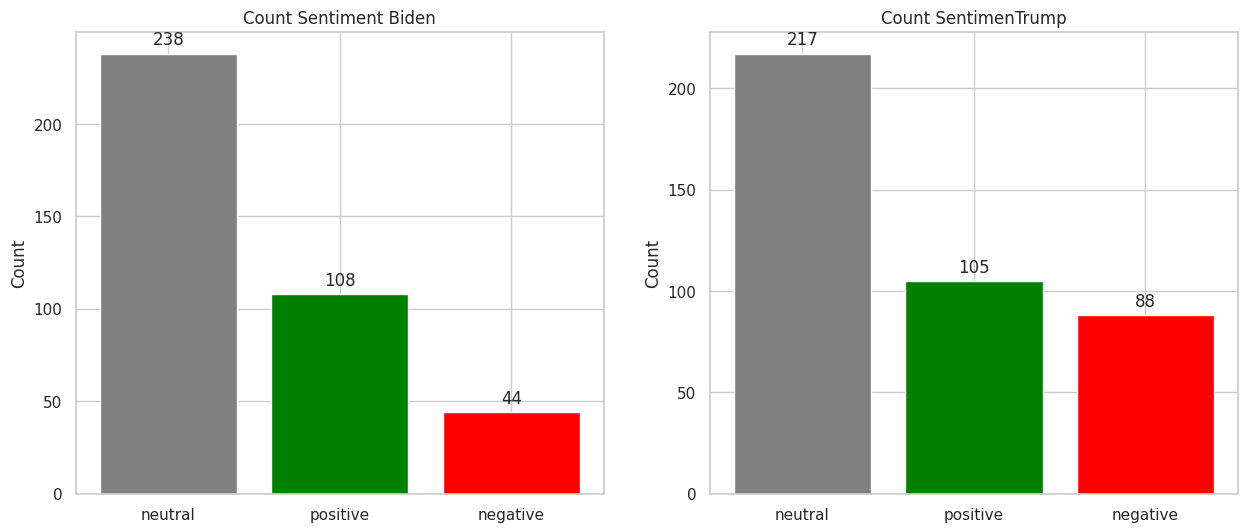

In [470]:
results = {'biden': {'neutral': 238, 'positive': 108, 'negative': 44},
           'trump': {'neutral': 217,'positive': 105, 'negative': 88, }}

colors = {'positive': 'green', 'negative': 'red', 'neutral': 'grey'}

def add_labels(ax):
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

bars_biden = axs[0].bar(results['biden'].keys(), results['biden'].values(), color=[colors[sentiment] for sentiment in results['biden'].keys()])
axs[0].set_ylabel('Count')
axs[0].set_title('Count Sentiment Biden')
add_labels(axs[0])

bars_trump = axs[1].bar(results['trump'].keys(), results['trump'].values(), color=[colors[sentiment] for sentiment in results['trump'].keys()])
axs[1].set_ylabel('Count')
axs[1].set_title('Count SentimenTrump')
add_labels(axs[1])

plt.show()



In [472]:
# add +1 for positive tweets and -1 for negative

points_trump = results['trump']['positive'] - results['trump']['negative']
points_biden = results['biden']['positive'] - results['biden']['negative']

# Exibe os resultados
print(f"Points Trump: {points_trump}")
print(f"Points Biden: {points_biden}")


Points Trump: 17
Points Biden: 64


Based on this brief analysis we can see that the possible president would be Biden.
Coincidentally, the president-elect was President Biden, but to be more certain that the tweets are related to the votes, we would need more analyses, such as the location of the tweet to know if the user is a voter in the USA, the number of interactions of the tweet to understand if other users support that opinion among others